# Final Project Submission

Please fill out:
* Student name:  Raizel Bernstein and Steven Yan
* Student pace:  Full-time
* Scheduled project review date/time:  Friday, November 13th / 10:30 AM
* Instructor name:  Fangfang Lee and Justin Tannenbaum
* Blog post URL:

# Web Scraping for Data Collection

## Import modules

We walk through step-by-step how we went about webscraping through the IMDB website with Beautiful Soup.  We import the following modules for webscraping: requests, time, random, and tqdm.  We import the following modules for data cleaning:  numpy and pandas.  Requests is the module we use for send the http requests to get the HTML files, which we use the module BeautifulSoup to parse.  Numpy is the module we use for certain mathematical operations and array manipulation.  Pandas is the module for organizing the data into a DataFrame, which facilitates data cleaning and analysis.  Time is a module for representing time in code and allows us to create pauses.during code execution, while random helps us to create pseudo-random numbers for the pauses in the code execution.  Tqdm creates the progress bar for executing code for API calling or webscraping.


In [24]:
import pandas as pd
import numpy as np
import requests
import time
import random
from tqdm.notebook import trange, tqdm
from bs4 import BeautifulSoup as BS
import json

## Web Scraping through One Entry

We are going to walk through the process of working through a single page before the process of applying the same process to multiple pages.  We start with the URL that we want to scrape.  We make a GET request from the API of the website, and we receive a Response object in return.  We pass the response into the BeautifulSoup constructor, which parses the document with the HTML parser.  We are then able to view the HTML document as a complex tree of Python objects.  

In [25]:
url = 'https://www.imdb.com/search/title/?groups=top_1000&sort=boxoffice_gross_us,desc'
response = requests.get(url)
soup = BS(response.text, "html.parser")



We identify the div class of lister-item mode-advanced to contain the information that we need.  We use the find() method to extract the first of the 50 div containers representing the top 50 of the 1000 on the webpage.  We try to put out the value of just one to make sure we have the right values.  We are grabbing movie titles, IMDB id's, PG ratings, the year of release, runtimes, genres, IMDB ratings, metascores, total number of votes submitted for IMDB rating, and gross US earnings.  

In [26]:
div = soup.find('div', {'class':'lister-item mode-advanced'})


In [27]:
title = div.h3.a.text
imdb_id = div.find('img')['data-tconst']
year = div.h3.find('span', class_='lister-item-year').text
pg_rating = div.find('span', class_='certificate').text
runtime = div.find('span', class_='runtime').text
genre = div.find('span', class_='genre').text
imdb_rating = div.strong.text
metascore = div.find('span', class_='metascore').text
nv = div.find_all('span', attrs={'name': 'nv'})
vote = nv[0].text
gross = nv[1].text


## Web Scraping through Multiple Entries on Multiple Pages

In order to iterate through all 50 instances and then to iterate through all 200 pages for the 1000 entries, we create a for loop to iterate through the 50 movies on each page and another for loop to iterate through each page.  First, we instantiate the variables that will represent each of the data we are gathering.

In [28]:
titles = []
imdb_ids = []
pg_ratings = []
years = []
runtimes = []
genres = []
imdb_ratings = []
metascores = []
votes = []
gross_us = []

To iterate through each page, we look at the URLs for each page containing 50 entries and find the pattern for iteration.  As we move past the 1st page through the pages, the value after start changes, from 51, 101, 151, 201, etc.  We postulate that if we substitute 1 we would get the original page.  We use string formatting to insert the different values we are iterating through.  We are iterating starting the range of 1 to 1000 at intervals of 50.  As we find the values, we append them to their respective lists.  When we started to run the for loops, we encountered errors.  We added to some of the original code to account for empty values to ensure all of our lists had 1000 values at the end.

In [29]:

for n in tqdm(range(1, 1000, 50), desc='Download Progress:'):
    # Create an expression that represents each page for the iteration
    url = 'https://www.imdb.com/search/title/?groups=top_1000&sort=boxoffice_gross_us,desc&start={}&ref_=adv_nxt'.format(n)
    # The requests library makes a get request to the url for data, which is saved to results
    results = requests.get(url)
    # Create an instance of BeautifulSoup to parse results
    soup = BS(results.text, "html.parser")
    # Find the div container in the HTML that contains the wanted information.  
    movie_div = soup.find_all('div', class_='lister-item mode-advanced')
    # Use function to suspend execution of calling thread at random
    time.sleep(random.randint(3, 12))

    # for each container in the div container created above by Beautiful Soup
    for div in movie_div:
        # to get the titles, we use attribute notation to access the title contained as text in the <a> tag nested inside the <h3> tag 
        # dot notation only works with the first instance of the tag
        title = div.h3.a.text
        # we append the scraped title to the titles list through each iteration
        titles.append(title)
        # to get the IMDB id's, we use the find() method to find the first instance 
        imdb_id = div.find('img')['data-tconst']
        imdb_ids.append(imdb_id)
        # to scrape the year, we use the find() method to search nested inside the h3 tag to get the text inside the span tag with the class lister-item-year
        year = div.h3.find('span', class_='lister-item-year').text
        years.append(year)
        # to scrape the pg rating, we use the find method again but create a condition in the case of blank values
        pg_rating = div.find('span', class_='certificate').text if div.p.find('span', class_='certificate') else '--'
        pg_ratings.append(pg_rating)
        # to scrape the runtime, we use a similar method from above
        runtime = div.find('span', class_='runtime').text if div.p.find('span', class_='runtime') else '--'
        runtimes.append(runtime)
        # to scrape the genres, we employed the same method
        genre = div.find('span', class_='genre').text
        genres.append(genre)
        # to scrape the IMDB rating, we call the distinctive strong tag which wraps the desired text
        imdb_rating = div.strong.text
        imdb_ratings.append(imdb_rating)
        # to scrape the etascore, we use a similar code as above
        metascore = div.find('span', class_='metascore').text if div.find('span', class_='metascore') else '--'
        metascores.append(metascore)
        # to scrape the votes and gross us earnings, we use the find_all method, which finds all the instances of the span tag with the name attribute and value of nv
        # if there is one item in the list, it represents the vote, and if there are two items, then we get the gross earning and return a string if it's empty to ensure all our lists are the same length to make the DataFrame
        nv = div.find_all('span', attrs={'name': 'nv'})
        vote = nv[0].text
        votes.append(vote)
        gross = nv[1].text if len(nv) > 1 else '--'
        gross_us.append(gross)
        



## Creating DataFrame for Data Cleaning

We then created a dataframe that would contain all the values of the lists with each column representing a different type of data.  This allows us to clean and manipulate the data more easily.

In [31]:
# Create a Pandas dataframe with the 
movies = pd.DataFrame({
    'movie': titles, 'year' : years, 'pg_rating' : pg_ratings, 'imdb_id' : imdb_ids, 'runtime' : runtimes, 'genre' : genres, 'metascore' : metascores, 'imdb_rating' : imdb_ratings, 'votes' : votes, 'gross_us' : gross_us
})


# Making API requests for Data Collection


We collected another data set from TMDB using their sample URL requests tool to create the appropriate URL to find the top 1000 most popular movies.  The code is very similar to the webscraping one, except that we create a request using the Request() constructor to fetch a .json file.  We call the json() method to read and parse the data into a dictionary.  The for loop iterates through each of the pages and appends the data into compiled_list.

## Making API calls

In [30]:
compiled_list = []

for n in tqdm(list(range(1,399))):
    url='https://api.themoviedb.org/3/movie/top_rated?api_key=0e72c0b2b11293a6390e9f7b472aec2b&language=en-US&page={}'.format(n)
    r = requests.get(url)
    data = r.json()
    compiled_list.append(data)
    time.sleep(random.choice([1,2]))


In [32]:
movies_2 = []
for page in compiled_list:
    movies_2 += page['results']

## Creating DataFrame

In [33]:
df = pd.DataFrame(movies_2)

# Data Cleaning

## Cleaning Web Scraping Data

To determine how the data needs to be cleaned, we called an entry from each columns to see the output. When the values are displayed inside the dataframe, we couldn't determine whether there was whitespace or not. We used df.dtypes to determine whch column values needed to be converted into the appropriate type.

In [34]:
# We used extract and regex to pull out any digits of length 1 or more and to turn that string into an integer type
movies['imdb_id'] = movies['imdb_id'].str.extract('(\d+)').astype(int)
movies['year'] = movies['year'].str.extract('(\d+)').astype(int)
movies['runtime'] = movies['runtime'].str.extract('(\d+)').astype(int)
# We used rstrip() to remove whitespace right of the metascore
movies['metascore'] = movies['metascore'].str.rstrip()
# Because of empty values, we can convert those non-numeric values to numeric with coerce
movies['metascore'] = pd.to_numeric(movies['metascore'], errors='coerce')
# We used replace() to remove the comma from the vote count and turn the value into an integer
movies['votes'] = movies['votes'].str.replace(',', '').astype(int)
# We used map() and lambda function to apply the lstrip() method and rstrip() method
movies['gross_us'] = movies['gross_us'].map(lambda x: x.lstrip('$').rstrip('M'))
# We used map() and lambda function to strip \n in front and whitespace after
movies['genre'] = movies['genre'].map(lambda x: x.strip('\n').rstrip())

In [35]:
# Write dataframe to a CSV file
movies.to_csv('top_1000_by_us_box_office.csv')

## Cleaning API Data

In [36]:
df.columns

Index(['popularity', 'id', 'video', 'vote_count', 'vote_average', 'title',
       'release_date', 'original_language', 'original_title', 'genre_ids',
       'backdrop_path', 'adult', 'overview', 'poster_path'],
      dtype='object')

In [37]:
df = df.drop(columns = ['backdrop_path', 'poster_path', 'video', 'adult', 'original_title', 'overview'])

Upon inspecting the data, we realized we had to convert the genre ID's into the actual genre names.  We achieved that by creating dictionary of key:value pairs, where the key is the ID and value is the genre name.  We passed the dictionary through each of the rows of the genre column to replace the values.

In [39]:
df.head()

,popularity,id,vote_count,vote_average,title,release_date,original_language,genre_ids
0,10.180,724089,924,8.9,Gabriel's Inferno Part II,2020-07-31,en,[10749]
1,11.049,696374,1542,8.8,Gabriel's Inferno,2020-05-29,en,[10749]
2,23.941,644479,257,8.7,Dedicated to my ex,2019-11-01,es,"[35, 18]"
3,54.581,278,17505,8.7,The Shawshank Redemption,1994-09-23,en,"[18, 80]"
4,15.683,19404,2419,8.7,Dilwale Dulhania Le Jayenge,1995-10-20,hi,"[35, 18, 10749]"


In [40]:
genre = {28: 'Action', 12: "Adventure", 16: 'Animation', 35: 'Comedy', 80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family', 14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music', 9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction', 10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'}

In [41]:
for g_id in df['genre_ids']:
    for g in g_id:
        if g not in genre.keys():
            print(g)

In [42]:
df['genre_ids'] = df['genre_ids'].apply(lambda g_id: [genre[g] for g in g_id])

## Combining data from two databases

We uploaded the CSV from the webscraping exercise, merged the two dataframes together, and inspected our resulting dataframe, and dropped extraneous columns.

In [43]:
top = pd.read_csv('top_1000_by_us_box_office.csv')
combined = pd.merge(df, top, left_on = 'title', right_on = 'movie')
combined.to_csv('combined.csv')
combined.columns

Index(['popularity', 'id', 'vote_count', 'vote_average', 'title',
       'release_date', 'original_language', 'genre_ids', 'Unnamed: 0', 'movie',
       'year', 'pg_rating', 'imdb_id', 'runtime', 'genre', 'metascore',
       'imdb_rating', 'votes', 'gross_us'],
      dtype='object')

In [44]:
combined = pd.read_csv('combined.csv')

In [47]:
combined = combined.drop(columns=['movie', 'Unnamed: 0', 'metascore', 'vote_count', 'vote_average', 'original_language', 'id'])

KeyError: "['movie' 'Unnamed: 0' 'metascore' 'vote_count' 'vote_average'\n 'original_language' 'id'] not found in axis"

We checked for any null values in the table, and dropped the rows which had null values for the gross earnings.  We also wanted to pull the month and the year out of the release date, so we could sort by month or year.  By checking dtypes, we saw that certain columns needed to be converted into integers.

In [46]:
combined.isna().sum()

popularity      0
title           0
release_date    0
genre_ids       0
Unnamed: 0.1    0
year            0
pg_rating       0
imdb_id         0
runtime         0
genre           0
imdb_rating     0
votes           0
gross_us        0
dtype: int64

In [48]:
combined['month'] = combined['release_date'].apply(lambda m: m[5:7])

In [49]:
combined['year'] = combined['year'].apply(lambda x: int(x))

In [50]:
combined['month'] = combined['month'].apply(lambda x: int(x))

There were no null values for the gross_us column, but by using value_counts() we could see that there were rows with the value of '--'.  We subsetted out the rows containing the string, and then converted the column to float values.

In [51]:
combined.gross_us.value_counts()
combined = combined[~combined.gross_us.str.contains("--")]
combined.gross_us = combined.gross_us.astype(float)

/Users/examsherpa/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# Data Analysis

At this point, we were ready to begin our analysis of the data.  We wanted ultimately to make recommendations to the Microsoft Team about which genre and release month is best for their next movie production.  The main two questions we want to answer are: what is the best genre for their next movie production?  what month should they release their next movie production?

In recommending the best genre, we will look at the distribution of genre films in our database, as well as analyzing the average gross revenue, average IMDB ratings, and average TMDB popularity per genre.

In recommending the release month, we plan to analyze the average gross revenue per month per genre. We conjecture that horror movies would have the most revenue around the months surrounding Halloween, but we will make a recommendation based on the data.


## Distribution of Gross Revenue

We looked at the distribution of gross revenues to determine whether the median or mean value would be a better measure of central tendency.  Based on the data below, we determined that the median values would be a better measure since it is a skewed distribution.

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("poster")
sns.set_style("darkgrid")

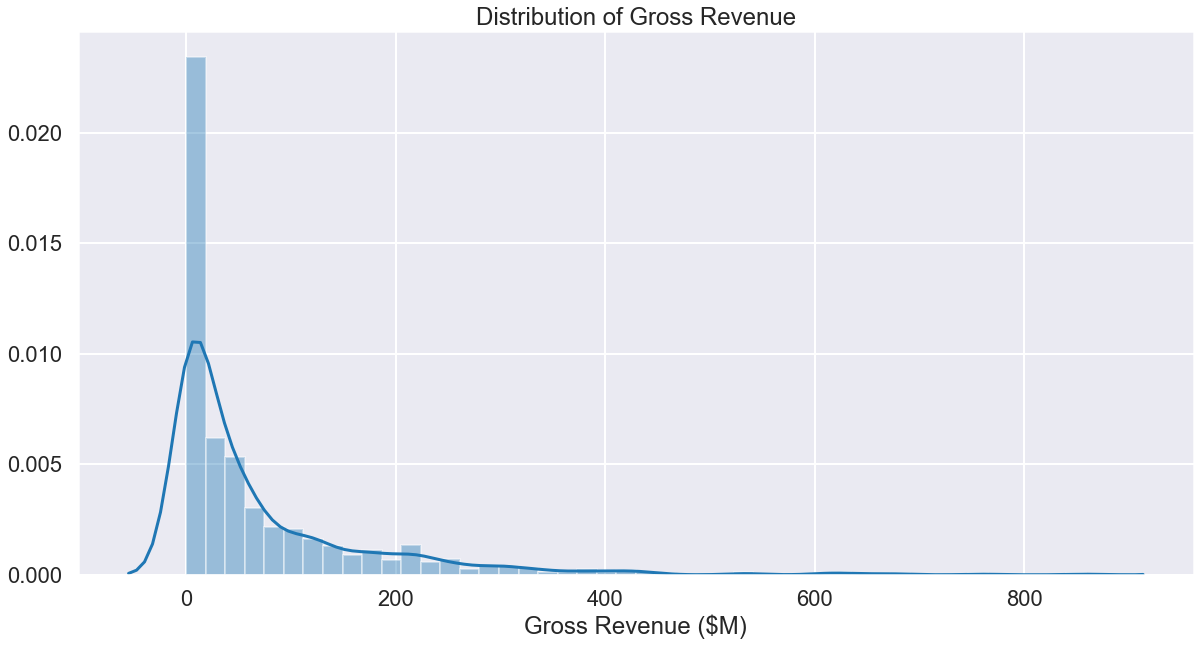

In [53]:
fig = plt.figure(figsize = (20, 10))

sns.distplot(combined.gross_us) 

plt.title("Distribution of Gross Revenue")
plt.xlabel("Gross Revenue ($M)")

plt.savefig("gross_earnings_distribution.jpg")

plt.show()

## Distribution of Films by Genre

We looked at the distribution of films by genre to get an initial sense of the sheer number of how much of each genre of movies has been produced.  Based on the data below, the top 3 genres are drama, thriller, and comedy.

In [54]:
combo = combined.explode('genre_ids')
combo.head()

,popularity,title,release_date,genre_ids,Unnamed: 0.1,year,pg_rating,imdb_id,runtime,genre,imdb_rating,votes,gross_us,month
0,54.581,The Shawshank Redemption,1994-09-23,"['Drama', 'Crime']",397,1994,R,111161,142,Drama,9.3,2304501,28.34,9
2,51.052,The Godfather,1972-03-14,"['Drama', 'Crime']",137,1972,R,68646,175,"Crime, Drama",9.2,1590501,134.97,3
3,34.026,Schindler's List,1993-11-30,"['Drama', 'History', 'War']",193,1993,R,108052,195,"Biography, Drama, History",8.9,1195736,96.90,11
4,109.474,Your Name.,2016-08-26,"['Romance', 'Animation', 'Drama']",590,2016,PG,5311514,106,"Animation, Drama, Fantasy",8.4,185501,5.02,8
5,35.941,The Godfather: Part II,1974-12-20,"['Drama', 'Crime']",265,1974,R,71562,202,"Crime, Drama",9.0,1111248,57.30,12


In [55]:
combo.gross_us.max()

858.37

/Users/examsherpa/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  # Remove the CWD from sys.path while we load stuff.


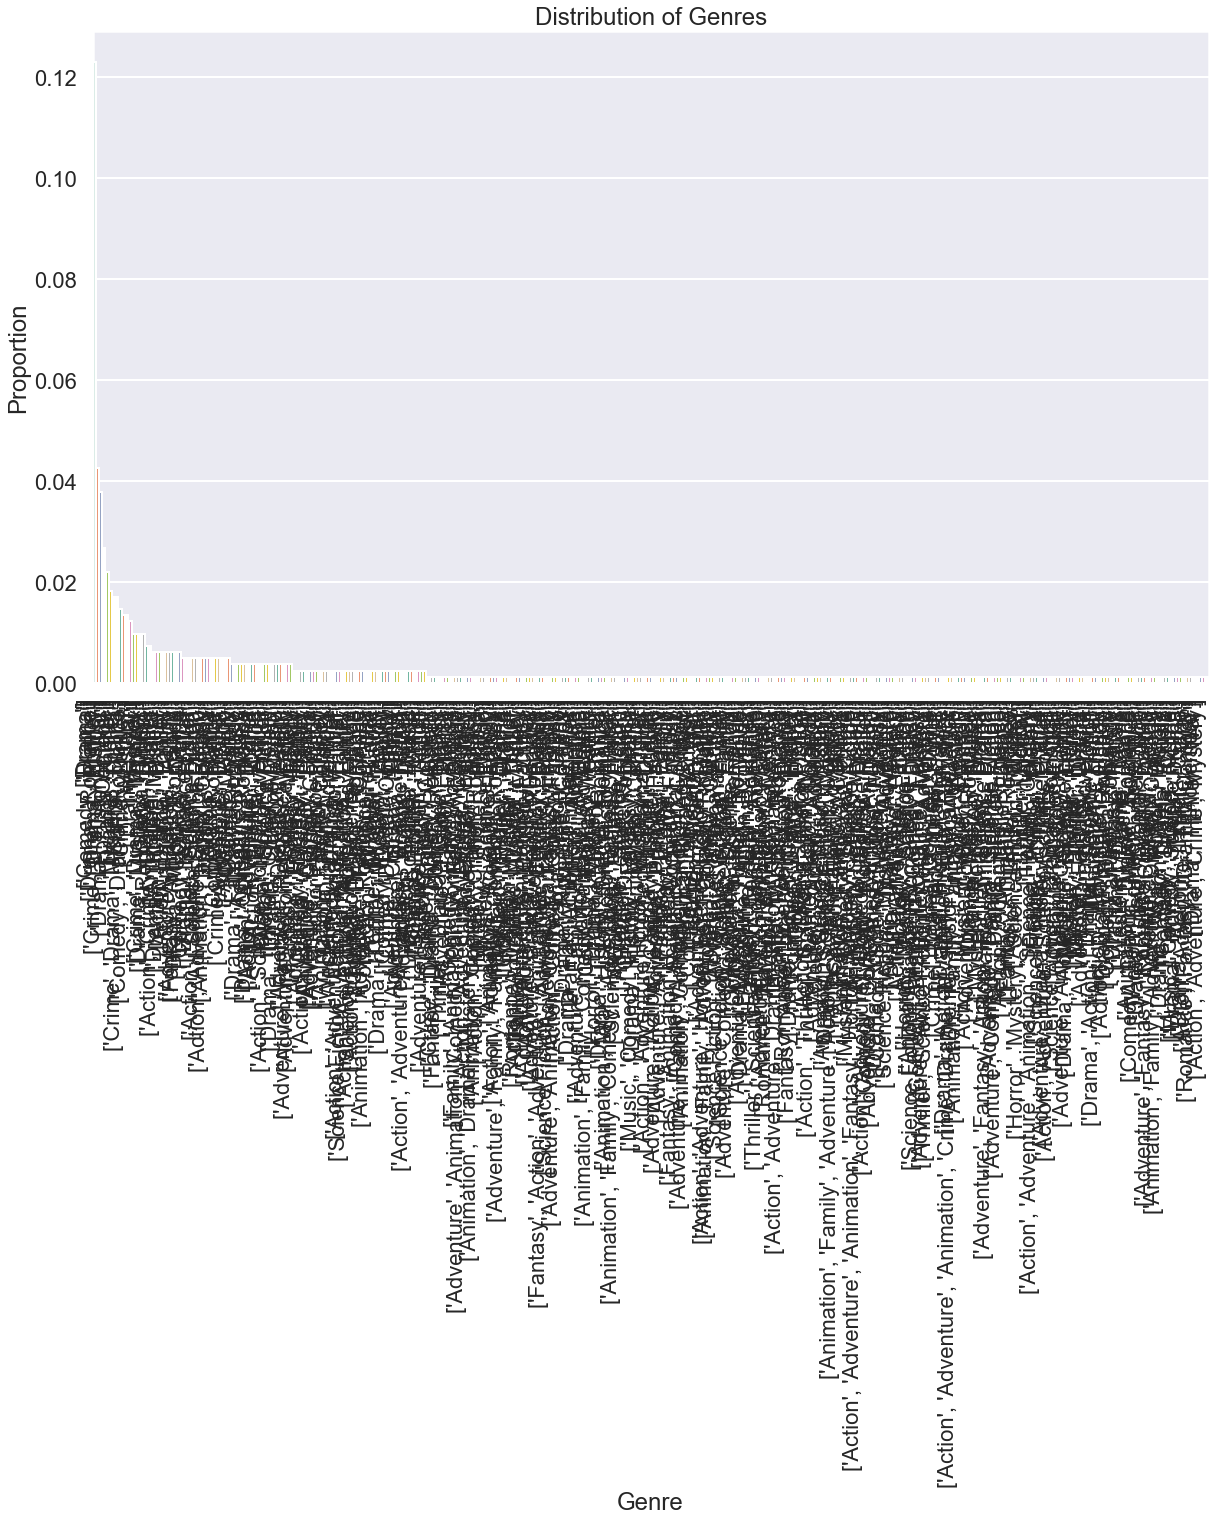

In [56]:
Y = combo.genre_ids.value_counts(normalize = True)
X = Y.index

fig = plt.figure(figsize = (20, 12))

g = sns.barplot(X, Y, palette = "Set2")
g.set(title = 'Distribution of Genres', ylabel = "Proportion", xlabel = "Genre")

plt.xticks(rotation=90, ha='right')
plt.tight_layout()

fig.savefig("Distribution_genre.png")

plt.show()

## Median Gross Revenue per Genre

We looked at the median gross revenue per genre to determine which genre was generating the most revenue at the box office. The two highest revenue generating genres are Action and Family.

/Users/examsherpa/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if sys.path[0] == '':


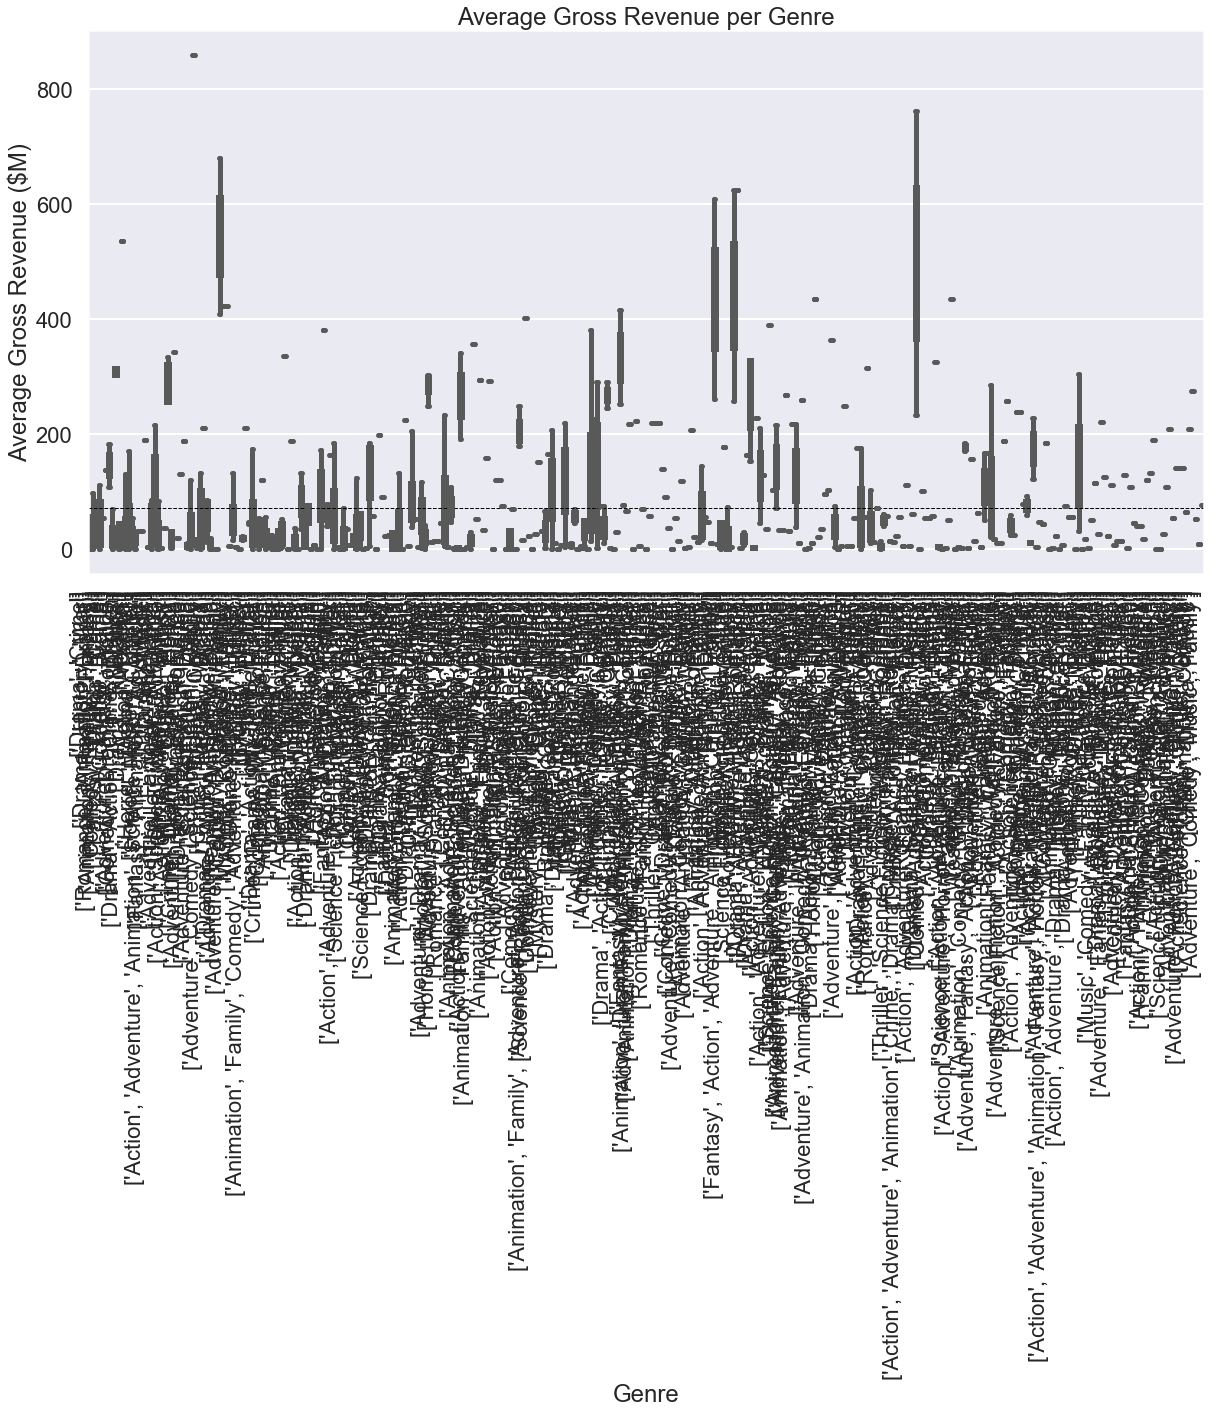

In [21]:
fig = plt.figure(figsize = (20, 10))

g = sns.boxplot(x = 'genre_ids', y = 'gross_us', data = combo, 
                showfliers = False, palette="Set2", linewidth = 5, fliersize= 1.5 )

g.set(title = 'Median Gross Revenue per Genre', 
      ylabel = "Median Gross Revenue ($M)", xlabel = "Genre")

plt.axhline(combo.gross_us.median(), ls='--', lw = 1, color = 'black')

plt.xticks(rotation=90, ha='right')
plt.tight_layout()

fig.savefig("Median_Gross_Earnings.png")

plt.show()

## Average IMDB Ratings Per Genre

/Users/examsherpa/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if sys.path[0] == '':


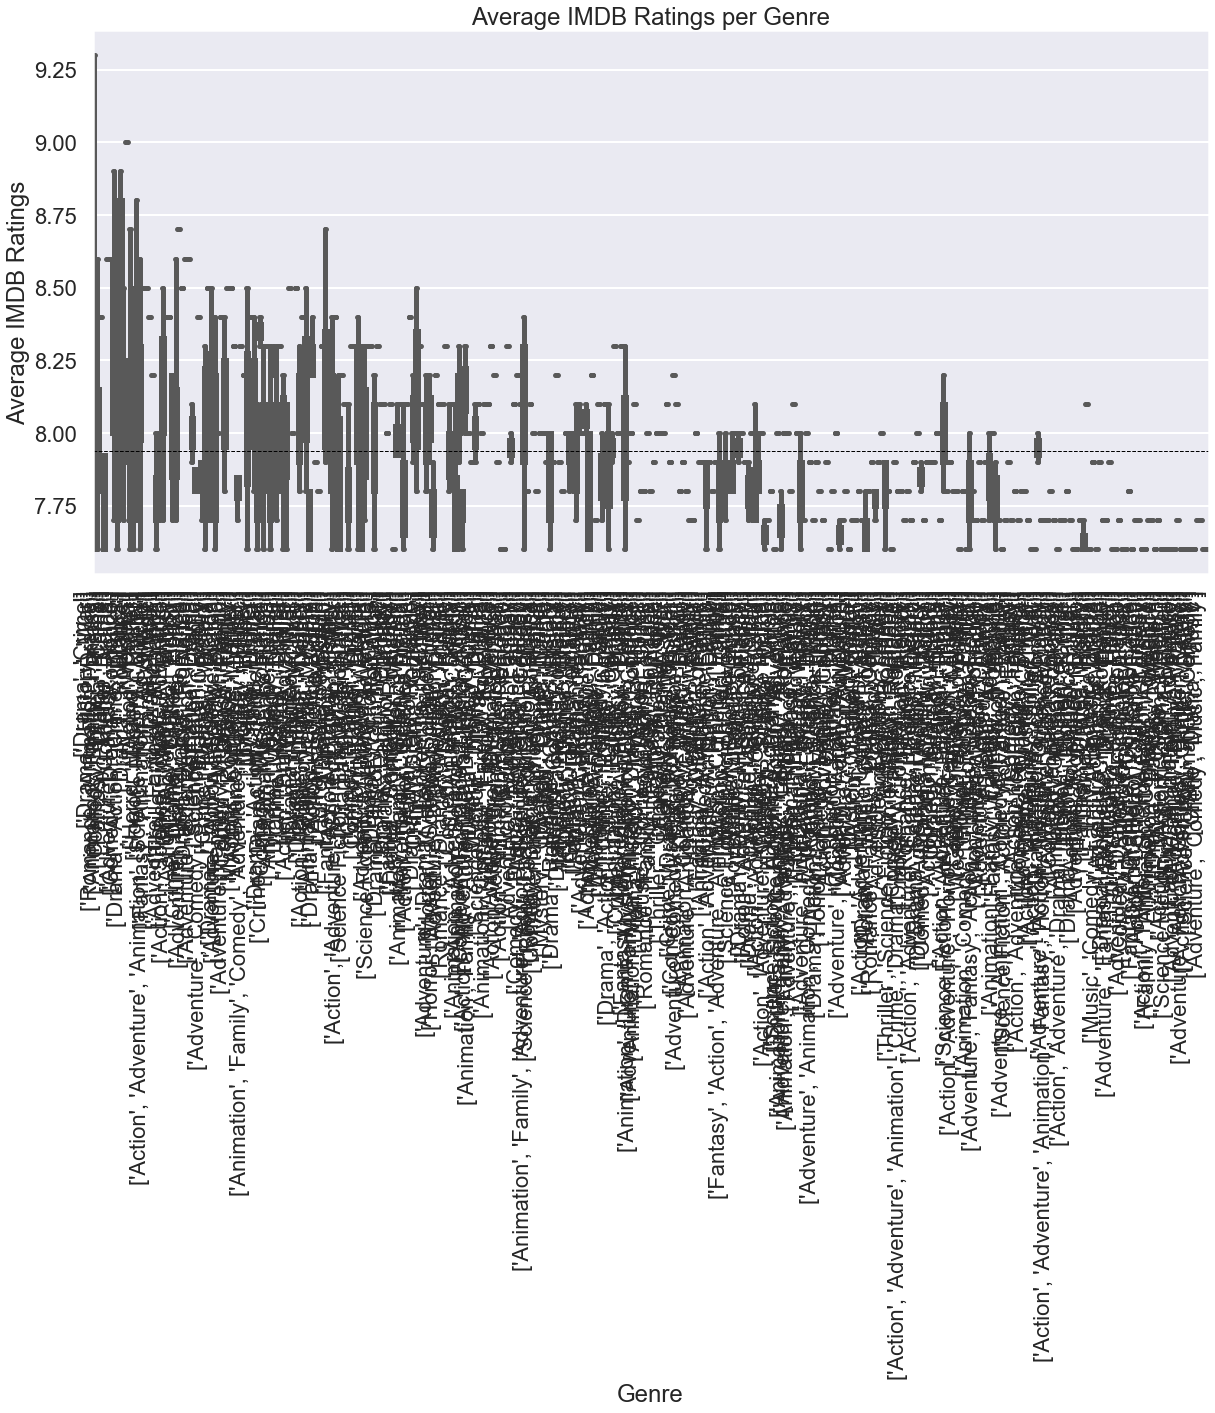

In [22]:
fig = plt.figure(figsize = (20, 10))

g = sns.boxplot(x = 'genre_ids', y = 'imdb_rating', data = combo, 
                showfliers = False, palette="Set2", linewidth = 5, fliersize= 1.5 )

g.set(title = 'Average IMDB Ratings per Genre', 
      ylabel = "Average IMDB Ratings", xlabel = "Genre")

plt.axhline(combo.imdb_rating.mean(), ls='--', lw = 1, color = 'black')

plt.xticks(rotation=90, ha='right')
plt.tight_layout()

fig.savefig("Average_IMDB_Ratings.png")

plt.show()

## Average TMDB Popularity per Genre

We looked at the average TMDB popularity per genre to determine what genre of movie was receiving the highest popularity ratings on TMDB. The genres of Animation and Family have the highest popularity ratings given by movie watchers on that site.

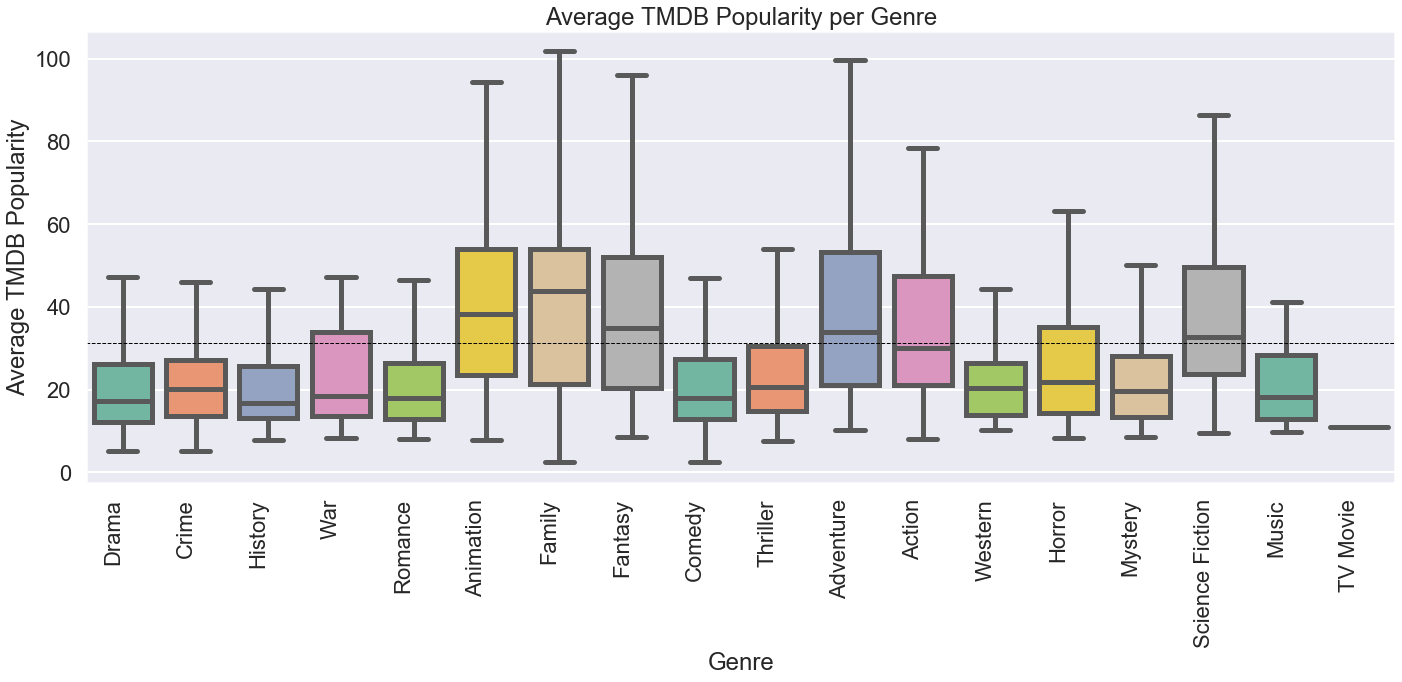

In [39]:
fig = plt.figure(figsize = (20, 10))

g = sns.boxplot(x = 'genre_ids', y = 'popularity', data = combo, 
                showfliers = False, palette="Set2", linewidth = 5, fliersize= 1.5 )

g.set(title = 'Average TMDB Popularity per Genre', 
      ylabel = "Average TMDB Popularity", xlabel = "Genre")

plt.axhline(combo.popularity.mean(), ls='--', lw = 1, color = 'black')

plt.xticks(rotation=90, ha='right')
plt.tight_layout()

fig.savefig("Average_TMDB_Popularity.png")

plt.show()

## Median Gross Earnings Per Month for each Genre

We wanted to make a recommendation for release month to Microsoft using our data.  Based on our findings on a preferred genre, we can look for the month with the highest median gross earning for that genre. We could also find the highest revenue-generating genre for each month.

Jan: War (60)
Feb: Adventure (250)
Mar: Family (200)
Apr: SciFi, Adventure (400)
May: Animation, Family (250)
Jun: Family, Fantasy, Animation (200)
Jul: Adventure, Action, War (200)
Aug: Music (160)
Sep: Western (50)
Oct: Fantasy, Adventure (200)
Nov: Animation, Family, Adventure (200)
Dec: SciFi, Adventure (200)

Western: Mar (100)
War: Jul (175)
Thriller: Apr (60)
TV Movie: Jan (5)
SciFi: Apr (400)
Romance: 

In [ ]:


month_genre_gross_median = combo.groupby(['month', 'genre_ids'])['gross_us'].median().unstack().transpose()
fig, axes = plt.subplots(3,4, figsize = (50, 30))

axes[0][0].set_title('Jan')
axes[0][1].set_title('Feb')
axes[0][2].set_title('Mar')
axes[0][3].set_title('Apr')
axes[1][0].set_title('May')
axes[1][1].set_title('Jun')
axes[1][2].set_title('Jul')
axes[1][3].set_title('Aug')
axes[2][0].set_title('Sep')
axes[2][1].set_title('Oct')
axes[2][2].set_title('Nov')
axes[2][3].set_title('Dec')

axes[0][0].set_xlabel('Avg gross USD in mil')
axes[0][1].set_xlabel('Avg gross USD in mil')
axes[0][2].set_xlabel('Avg gross USD in mil')
axes[0][0].set_xlabel('Avg gross USD in mil')
axes[1][0].set_xlabel('Avg gross USD in mil')
axes[1][1].set_xlabel('Avg gross USD in mil')
axes[1][2].set_xlabel('Avg gross USD in mil')
axes[1][3].set_xlabel('Avg gross USD in mil')
axes[2][0].set_xlabel('Avg gross USD in mil')
axes[2][1].set_xlabel('Avg gross USD in mil')
axes[2][2].set_xlabel('Avg gross USD in mil')
axes[2][3].set_xlabel('Avg gross USD in mil')

axes[0][0].set_ylabel('Genre')
axes[0][1].set_ylabel('Genre')
axes[0][2].set_ylabel('Genre')
axes[0][3].set_ylabel('Genre')
axes[1][0].set_ylabel('Genre')
axes[1][1].set_ylabel('Genre')
axes[1][2].set_ylabel('Genre')
axes[1][3].set_ylabel('Genre')
axes[2][0].set_ylabel('Genre')
axes[2][1].set_ylabel('Genre')
axes[2][2].set_ylabel('Genre')
axes[2][3].set_ylabel('Genre')

x = month_genre_gross_median.index
Jan = month_genre_gross_median[1]
Feb = month_genre_gross_median[2]
Mar = month_genre_gross_median[3]
Apr = month_genre_gross_median[4]
May = month_genre_gross_median[5]
June = month_genre_gross_median[6]
July = month_genre_gross_median[7]
Aug = month_genre_gross_median[8]
Sep = month_genre_gross_median[9]
Oct = month_genre_gross_median[10]
Nov = month_genre_gross_median[11]
Dec = month_genre_gross_median[12]

axes[0][0].barh(x, Jan, color = 'gray')
axes[0][1].barh(x, Feb, color = 'red')
axes[0][2].barh(x, Mar, color = 'orange')
axes[0][3].barh(x, Apr, color = 'green')
axes[1][0].barh(x, May, color = 'pink')
axes[1][1].barh(x, June, color = 'dodgerblue')
axes[1][2].barh(x, July, color = 'black')
axes[1][3].barh(x, Aug, color = 'purple')
axes[2][0].barh(x, Sep, color = 'yellow')
axes[2][1].barh(x, Oct, color = 'lime')
axes[2][2].barh(x, Nov, color = 'brown')
axes[2][3].barh(x, Dec, color = 'silver')

In [ ]:
g = sns.FaceGrid(combo, col='genre',)

In [1]:
combined.year.value_counts()

NameError: name 'combined' is not defined

In [ ]:
runtime = df.groupby('year')['runtime'].mean()
plt.plot(runtime)
plt.xlabel('Years', size=12)
plt.ylabel('Runtime: Movie Length, minutes', size=12)